<img src="figure/clairvoyance_logo.png">

# Clairvoyance: Active sensing on time-series prediction

## ML-AIM (http://vanderschaar-lab.com/)

This notebook describes the user-guide of an active sensing application using Clairvoyance framework. Active sensing problem is defined as following: recommend when and what measurements should we observe to maximize the prediction accuracy with respect to measurement cost constraints. For instance, active sensing model can recommend to doctors which vitals and lab tests should they observe and when for better understanding the patient states.
 
<img src="figure/active-sensing-definition.png">

To run this tutorial, you need:
### Temporal and static datasets for training and testing

If users come with their own temporal and static datasets for training and testing, the users should save those files as 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.


### Prerequisite
Clone https://github.com/jsyoon0823/time-series-automl.git to the current directory.

## Active sensing pipeline summary

<img src="figure/active-sensing-block-diagram.png">

### Step 1: Load dataset
  - Extract csv files from the original raw datasets in ../datasets/data/data_name/ directory.  
  
### Step 2: Preprocess dataset
  - Preprocessing the raw data using various filters such as (1) replacing negative values to NaN, (2) do one-hot encidng for certain features, (3) do normalization.  
  
### Step 3: Define problem
  - Set the time-series prediction problem that we want to solve for active sensing. Set the problem (whether it is one-shot or online prediction), set the label, set the maximum sequence length, and set the treatment features. We also define the metric for evaluation and the task itself (whether classification or regression).

### Step 4: Impute dataset
  - Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  
### Step 5: Feature selection
  - Select the relevant static and temporal features to the labels. You can skip the feature selection (set feature selection method = None).
  
### Step 6: Active sensing model fit and predict
  - After finishing the data preparation, we define the active sensing models and train the model using the training dataset. After training, we use the trained model to recommend future measurements on the testing dataset.
  
### Step 7: Visualize results
  - Visualize the recommendations of the future measurements.

## Step 0: Import necessary packages

Import necessary packages for the entire tutorials.

In [1]:
# Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('../')

from utils import PipelineComposer

## Step 1: Load dataset

Extract temporal and static datasets from 'data_name_temporal_train_data_eav.csv.gz', 'data_name_static_train_data.csv.gz', 'data_name_temporal_test_data_eav.csv.gz', 'data_name_static_test_data.csv.gz' in '../datasets/data/data_name/' directory.

- CSVLoader: Load csv files from the original raw datasets in ../datasets/data/data_name/ directory.
- file_names: mimic in this tutorial.

In [2]:
from datasets import CSVLoader

# Define data name
data_name = 'mimic'
# Define data dictionary
data_directory = '../datasets/data/'+data_name + '/' + data_name + '_'

# Load train and test datasets
data_loader_training = CSVLoader(static_file=data_directory + 'static_train_data.csv.gz',
                                 temporal_file=data_directory + 'temporal_train_data_eav.csv.gz')

data_loader_testing = CSVLoader(static_file=data_directory + 'static_test_data.csv.gz',
                                temporal_file=data_directory + 'temporal_test_data_eav.csv.gz')

dataset_training = data_loader_training.load()
dataset_testing = data_loader_testing.load()

print('Finish data loading.')

Finish data loading.


## Step 2: Preprocess dataset

Preprocess the raw data using multiple filters. In this tutorial, we replace all the negative values to NaN (using NegativeFilter), do one-hot encoding on 'admission_type' feature (using OneHotEncoder), and do MinMax Normalization (using Normalization). Preprocessing is done for both training and testing datasets. 
  - NegativeFilter: Replace negative values to NaN
  - OneHotEncoder: One hot encoding certain features
    - one_hot_encoding: input features that need to be one-hot encoded
  - Normalization (3 options): MinMax, Standard, None

In [3]:
from preprocessing import FilterNegative, OneHotEncoder, Normalizer

# (1) filter out negative values
negative_filter = FilterNegative()
# (2) one-hot encode categorical features
one_hot_encoding = 'admission_type'
onehot_encoder = OneHotEncoder(one_hot_encoding_features=[one_hot_encoding])
# (3) Normalize features: 3 options (minmax, standard, none)
normalization = 'minmax'
normalizer = Normalizer(normalization)

# Data preprocessing
filter_pipeline = PipelineComposer(negative_filter, onehot_encoder, normalizer)

dataset_training = filter_pipeline.fit_transform(dataset_training)
dataset_testing = filter_pipeline.transform(dataset_testing)

print('Finish preprocessing.')

Finish preprocessing.


## Step 3: Define problem   

Set the active sensing problem that we want to solve. Set the problem (whether it is one-shot or online prediction), set the label, set the maximum sequence length, and set the treatment features. We also define the metric for evaluation and the task itself (whether classification or regression). In this tutorial, we solve the active sensing problem on predicting whether the patients will die at the end of the hospital stay (one-shot setting).
  - problem: 'one-shot'(one time prediction) or 'online'(rolling window prediction)
    - 'one-shot': one time prediction at the end of the time-series 
    - 'online': preditcion at every time stamps of the time-series
  - max_seq_len: maximum sequence length of time-series sequence
  - label_name: the column name for the label(s)
  - treatment: the column name for treatments
  - window: x-hour ahead prediction (for online prediction).
  
  - other parameters:
    - metric_name: auc, apr, mse, mae
    - task: classification or regression

In [4]:
from preprocessing import ProblemMaker

# Define parameters
problem = 'one-shot'
max_seq_len = 24
label_name = 'death'
treatment = None
window = 0

# Define problem 
problem_maker = ProblemMaker(problem=problem, label=[label_name],
                             max_seq_len=max_seq_len, treatment=treatment, window = window)

dataset_training = problem_maker.fit_transform(dataset_training)
dataset_testing = problem_maker.fit_transform(dataset_testing)

# Set other parameters
metric_name = 'auc'
task = 'classification'

metric_sets = [metric_name]
metric_parameters =  {'problem': problem, 'label_name': [label_name]}

print('Finish defining problem.')

100%|██████████| 4610/4610 [00:08<00:00, 541.07it/s]


Finish defining problem.


## Step 4: Impute dataset

Impute missing values in the preprocessed static and temporal datasets and return complete datasets.
  - Static imputation (6 options): mean, median, mice, missforest, knn, gain
  - Temporal imputation (8 options): mean, median, linear, quadratic, cubic, spline, mrnn, tgain

In [5]:
from imputation import Imputation

# Set imputation models
static_imputation_model = 'median'
temporal_imputation_model = 'median'

# Impute the missing data
static_imputation = Imputation(imputation_model_name = static_imputation_model, data_type = 'static')
temporal_imputation = Imputation(imputation_model_name = temporal_imputation_model, data_type = 'temporal')

imputation_pipeline = PipelineComposer(static_imputation, temporal_imputation)

dataset_training = imputation_pipeline.fit_transform(dataset_training)
dataset_testing = imputation_pipeline.transform(dataset_testing)

print('Finish imputation.')

Using TensorFlow backend.


Finish imputation.


## Step 5: Feature selection

Select the relevant static and temporal features to the labels. If you do not want, we can skip the feature selection (set feature selection method = None).
  - feature selection method: 
      - feature_selection_model: greedy-addition, greedy-deletion, recursive-addition, recursive-deletion, None
      - feature_number: selected featuer number

In [6]:
from feature_selection import FeatureSelection

# Set feature selection parameters
static_feature_selection_model = None
temporal_feature_selection_model = None
static_feature_selection_number = None
temporal_feature_selection_number = None

# Select relevant features
static_feature_selection = \
FeatureSelection(feature_selection_model_name = static_feature_selection_model,
                 feature_type = 'static', feature_number = static_feature_selection_number,
                 task = task, metric_name = metric_name,
                 metric_parameters = metric_parameters)

temporal_feature_selection = \
FeatureSelection(feature_selection_model_name = temporal_feature_selection_model,
                 feature_type = 'temporal', feature_number = temporal_feature_selection_number,
                 task = task, metric_name = metric_name,
                 metric_parameters = metric_parameters)

feature_selection_pipeline = PipelineComposer(static_feature_selection, temporal_feature_selection)

dataset_training = feature_selection_pipeline.fit_transform(dataset_training)
dataset_testing = feature_selection_pipeline.transform(dataset_testing)

print('Finish feature selection.')

Finish feature selection.


## Step 6: Active sensing model fit and predict

After finishing the data preparation, we define the active sensing models (2 options, ASAC and DeepSensing), and train the active sensing model using the training dataset. We set validation set as the 20% of the training set for early stopping and best model saving. After training, we use the trained model to recommend the future measurements on the testing dataset.

- predictor_parameters:
  - active_sensing_model_name: asac, deepsensing
  - model_parameters: network parameters such as numer of layers
    - model_name: rnn, gru, lstm
    - h_dim: hidden dimensions
    - n_layer: layer number
    - n_head: head number (only for transformer model)
    - batch_size: number of samples in mini-batch
    - epochs: number of epochs
    - learning_rate: learning rate
  - static_mode: how to utilize static features (concatenate or None)
  - time_mode: how to utilize time information (concatenate or None)

In [7]:
from active_sensing import active_sensing

# Set active sensing model
active_sensing_model_name = 'asac'

# Set active sensing model parameters
model_parameters = {'h_dim': 100,
                    'n_layer': 2,
                    'batch_size': 128,
                    'epoch': 20,
                    'model_type': 'gru',
                    'learning_rate': 0.001,
                    'static_mode': 'Concatenate',
                    'time_mode': 'Concatenate',
                    'verbose': True}

# Set up validation for early stopping and best model saving
dataset_training.train_val_test_split(prob_val=0.2, prob_test = 0.0)


# Train the original predictive model
active_sensing_class = active_sensing(active_sensing_model_name, model_parameters, task)
active_sensing_class.fit(dataset_training)
# Return the observation recommendations on the testing set
test_s_hat = active_sensing_class.predict(dataset_testing)

print('Finish active sensing model training and testing.')

Train on 14792 samples, validate on 3698 samples
Epoch 1/20
14792/14792 [==============================] - 12s 827us/sample - loss: 0.3319 - select_loss: 0.1275 - predict_loss: 0.3308 - val_loss: 0.3293 - val_select_loss: 0.1070 - val_predict_loss: 0.3283
Epoch 2/20
14792/14792 [==============================] - 10s 682us/sample - loss: 0.3067 - select_loss: 0.1069 - predict_loss: 0.3055 - val_loss: 0.3173 - val_select_loss: 0.1061 - val_predict_loss: 0.3163
Epoch 3/20
14792/14792 [==============================] - 10s 675us/sample - loss: 0.3005 - select_loss: 0.1049 - predict_loss: 0.2994 - val_loss: 0.3135 - val_select_loss: 0.1041 - val_predict_loss: 0.3124
Epoch 4/20
14792/14792 [==============================] - 10s 676us/sample - loss: 0.2909 - select_loss: 0.1032 - predict_loss: 0.2898 - val_loss: 0.3038 - val_select_loss: 0.1016 - val_predict_loss: 0.3026
Epoch 5/20
14792/14792 [==============================] - 10s 704us/sample - loss: 0.2827 - select_loss: 0.1022 - predict_l

## Step 7: Visualize results

  - Recommend future measurements on the testing dataset.

Recommended Future Measurements


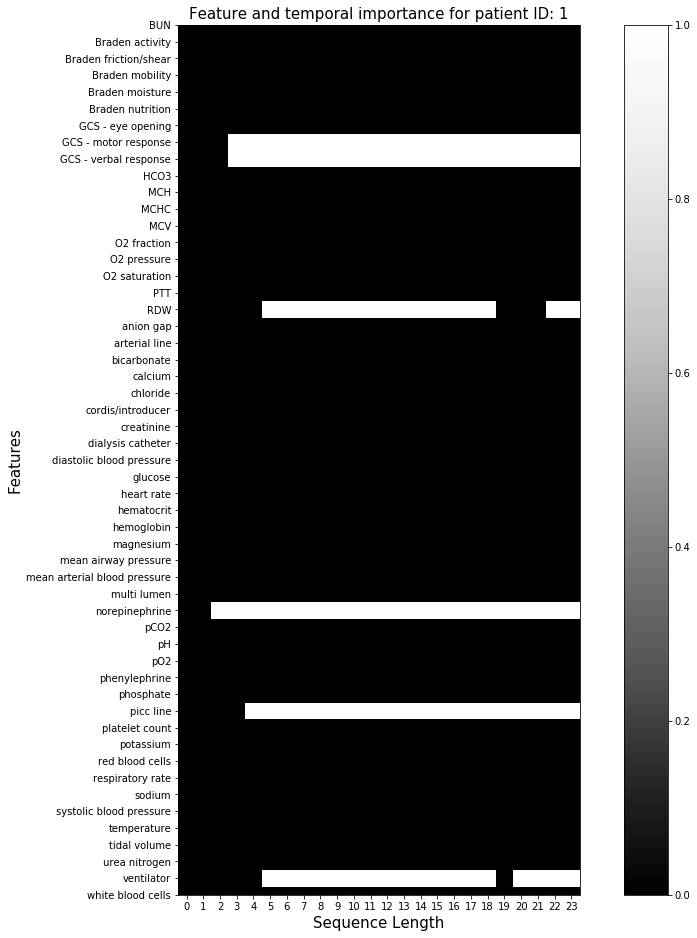

In [9]:
from evaluation import Metrics
from evaluation import print_interpretation

# Set the patient index for visualization
index = [1]

# Visualize the output
print('Recommended Future Measurements')
print_interpretation (test_s_hat[index], dataset_testing.feature_name, 
                      metric_parameters, model_parameters)